# Analysis and insights Python script: Retail market analysis in Barcelona
## Part 2: Creating the data mart

### In this part we are going to:
- Access the database
- Import all the data as dataframes
- Clean each dataframe
- Create the data mart
- Save the data mart in the database

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa
import folium

## Import the data

### Internal data: SQLite database

In [2]:
con = sa.create_engine("sqlite:///data/airbnb.db")

In [3]:
from sqlalchemy import inspect
insp = inspect(con)
tables = insp.get_table_names()
tables

['df', 'df_final', 'listings', 'listings_det']

Load all the tables

In [4]:
# We can load all the dataframes dynamically using their own names 
# with the exec function.

for table in tables:
    exec(f'{table} = pd.read_sql(table, con=con)')

In [5]:
# We can also print the dimension of each dataframe from another loop
# with the eval function, so the name of the table can be understood as an object, not like a string.

for table in tables:
    print(table + ": " + str(eval(table).shape))

df: (10790, 22)
df_final: (10790, 32)
listings: (15778, 19)
listings_det: (15778, 76)


### External data: Idealista web data

We don't have the property price in our dataframes, and it is one of the levers of our project. 

Then we are going to obtain that data from this webpage: [https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/cataluna/barcelona-provincia/barcelona/](https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/cataluna/barcelona-provincia/barcelona/)

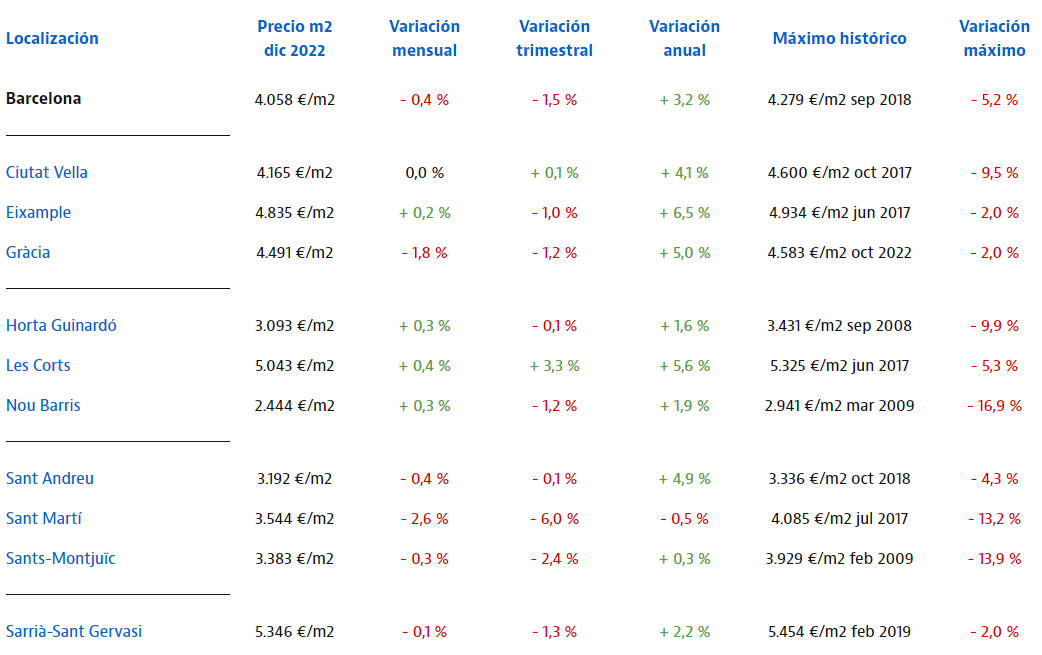

In [6]:
from IPython import display
display.Image("images/idealista.png")

In order to scrap the data we could inspect the HTML code and use BeatifulSoup to scrap it. However, to make the project shorter another tool is used.

Google Chrome extension "Instant Data Scraper" is used. In this way, a .csv file can be directly downloaded from the webpage in a table format.

In [7]:
pd.read_csv("data/idealista.csv")

,table__cell,table__cell 2,table__cell 3,table__cell 4,table__cell 5,table__cell 7,icon-elbow,icon-elbow href
0,Barcelona,4.058 €/m2,"- 0,4 %","- 1,5 %","+ 3,2 %","- 5,2 %",NaN,NaN
1,4.165 €/m2,"0,0 %","- 9,5 %",NaN,"+ 0,1 %","+ 4,1 %",Ciutat Vella,https://www.idealista.com/sala-de-prensa/infor...
2,4.835 €/m2,4.934 €/m2 jun 2017,"- 1,0 %","- 2,0 %","+ 0,2 %","+ 6,5 %",Eixample,https://www.idealista.com/sala-de-prensa/infor...
3,4.491 €/m2,4.583 €/m2 oct 2022,"- 1,8 %","- 1,2 %","+ 5,0 %","- 2,0 %",Gràcia,https://www.idealista.com/sala-de-prensa/infor...
4,3.093 €/m2,3.431 €/m2 sep 2008,"- 0,1 %","- 9,9 %","+ 0,3 %","+ 1,6 %",Horta Guinardó,https://www.idealista.com/sala-de-prensa/infor...
5,5.043 €/m2,5.325 €/m2 jun 2017,"- 5,3 %","+ 5,6 %","+ 0,4 %","+ 3,3 %",Les Corts,https://www.idealista.com/sala-de-prensa/infor...
6,2.444 €/m2,2.941 €/m2 mar 2009,"- 1,2 %","- 16,9 %","+ 0,3 %","+ 1,9 %",Nou Barris,https://www.idealista.com/sala-de-prensa/infor...
7,3.192 €/m2,3.336 €/m2 oct 2018,"- 0,4 %","- 0,1 %","+ 4,9 %","- 4,3 %",Sant Andreu,https://www.idealista.com/sala-de-prensa/infor...
8,3.544 €/m2,4.085 €/m2 jul 2017,"- 2,6 %","- 6,0 %","- 13,2 %","- 0,5 %",Sant Martí,https://www.idealista.com/sala-de-prensa/infor...
9,3.383 €/m2,3.929 €/m2 feb 2009,"- 0,3 %","- 2,4 %","+ 0,3 %","- 13,9 %",Sants-Montjuïc,https://www.idealista.com/sala-de-prensa/infor...


In [8]:
price_m2 = pd.read_csv("data/idealista.csv").loc[1:,["table__cell","icon-elbow"]].rename(columns={"table__cell": "price_m2", "icon-elbow":"neighbourhood_group"})
price_m2.head()

,price_m2,neighbourhood_group
1,4.165 €/m2,Ciutat Vella
2,4.835 €/m2,Eixample
3,4.491 €/m2,Gràcia
4,3.093 €/m2,Horta Guinardó
5,5.043 €/m2,Les Corts


We need to clean the "price_m2" feature.

In [9]:
price_m2["price_m2"] = price_m2["price_m2"].apply(lambda x: x.split(" ")[0].replace(".","")).astype("int")
price_m2.head()

,price_m2,neighbourhood_group
1,4165,Ciutat Vella
2,4835,Eixample
3,4491,Gràcia
4,3093,Horta Guinardó
5,5043,Les Corts


## Cleaning the data
### listings dataframe

In [10]:
listings.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia And Maria,Eixample,la Sagrada Família,41.40556,2.17262,Entire home/apt,129,1,33,2022-10-07,0.28,20,264,11,HUTB-002062
1,1,23197,"Forum CCIB DeLuxe, Spacious, Elegant ,Christmas",90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41243,2.21975,Entire home/apt,195,4,65,2022-10-23,0.45,2,255,12,HUTB005057
2,2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,73,2,83,2022-12-09,0.60,3,276,20,HUTB-001722
3,3,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,174,5,190,2022-11-19,1.28,1,139,30,HUTB-001506
4,4,36763,In front of the beach,158596,Ester,Ciutat Vella,la Barceloneta,41.38043,2.19094,Private room,36,31,104,2022-10-05,0.76,1,259,19,None


In [11]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15778 entries, 0 to 15777
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           15778 non-null  int64  
 1   id                              15778 non-null  int64  
 2   name                            15769 non-null  object 
 3   host_id                         15778 non-null  int64  
 4   host_name                       15776 non-null  object 
 5   neighbourhood_group             15778 non-null  object 
 6   neighbourhood                   15778 non-null  object 
 7   latitude                        15778 non-null  float64
 8   longitude                       15778 non-null  float64
 9   room_type                       15778 non-null  object 
 10  price                           15778 non-null  int64  
 11  minimum_nights                  15778 non-null  int64  
 12  number_of_reviews               

#### Variables and data types

We are going to remove all the features we don't need for this project. 

In [12]:
to_remove = ['index',
              'host_name',
              'number_of_reviews',
              'last_review',
              'reviews_per_month',
              'calculated_host_listings_count',
              'number_of_reviews_ltm',
              'license'
             ]

listings.drop(columns=to_remove, inplace=True)
listings.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365
0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Eixample,la Sagrada Família,41.40556,2.17262,Entire home/apt,129,1,264
1,23197,"Forum CCIB DeLuxe, Spacious, Elegant ,Christmas",90417,Sant Martí,el Besòs i el Maresme,41.41243,2.21975,Entire home/apt,195,4,255
2,32711,Sagrada Familia area - Còrsega 1,135703,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,73,2,276
3,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,174,5,139
4,36763,In front of the beach,158596,Ciutat Vella,la Barceloneta,41.38043,2.19094,Private room,36,31,259


Check the data types

In [13]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15778 entries, 0 to 15777
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15778 non-null  int64  
 1   name                 15769 non-null  object 
 2   host_id              15778 non-null  int64  
 3   neighbourhood_group  15778 non-null  object 
 4   neighbourhood        15778 non-null  object 
 5   latitude             15778 non-null  float64
 6   longitude            15778 non-null  float64
 7   room_type            15778 non-null  object 
 8   price                15778 non-null  int64  
 9   minimum_nights       15778 non-null  int64  
 10  availability_365     15778 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.3+ MB


Conclusion: change the object dtypes to categorical

In [14]:
for i in listings.select_dtypes("object").columns.to_list():
    listings[i] = listings[i].astype("category")

In [15]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15778 entries, 0 to 15777
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   15778 non-null  int64   
 1   name                 15769 non-null  category
 2   host_id              15778 non-null  int64   
 3   neighbourhood_group  15778 non-null  category
 4   neighbourhood        15778 non-null  category
 5   latitude             15778 non-null  float64 
 6   longitude            15778 non-null  float64 
 7   room_type            15778 non-null  category
 8   price                15778 non-null  int64   
 9   minimum_nights       15778 non-null  int64   
 10  availability_365     15778 non-null  int64   
dtypes: category(4), float64(2), int64(5)
memory usage: 1.5 MB


#### Nulls analysis

In [16]:
listings.isna().sum()

id                     0
name                   9
host_id                0
neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
availability_365       0
dtype: int64

We see there are 9 null values from the variable name

In [17]:
listings[listings["name"].isna()]

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365
1334,3518018,NaN,17713529,Eixample,Sant Antoni,41.38128,2.15940,Private room,60,1,0
1618,5046602,NaN,26052422,Sants-Montjuïc,la Marina de Port,41.35913,2.13557,Private room,65,1,0
1895,6870003,NaN,36001673,Sant Martí,el Clot,41.40582,2.18660,Private room,45,1,0
2052,7194911,NaN,37648307,Eixample,la Dreta de l'Eixample,41.39846,2.17397,Private room,40,3,0
2196,7576999,NaN,14415017,Sarrià-Sant Gervasi,el Putxet i el Farró,41.40479,2.14138,Private room,30,1,0
2214,7601123,NaN,39373198,Eixample,Sant Antoni,41.37574,2.16154,Private room,30,1,0
2321,8827248,NaN,42395411,Eixample,la Sagrada Família,41.40309,2.18285,Private room,28,1,0
3002,13683831,NaN,79467759,Sants-Montjuïc,Sants,41.38013,2.13732,Private room,50,3,0
3070,13748714,NaN,80531081,Sant Martí,el Poblenou,41.39719,2.20463,Private room,25,1,0


In this case the name of the host is not relevant for the analysis. Then, it is not gonna be changed.

#### Duplicate analysis

In [18]:
listings.duplicated().sum()

0

#### Categorical dtypes analysis
We are going to check the values and frequencies of the categorical variables.

In this case, the variable "name" is not analysed since it is not relevant for the project.

In [19]:
listings["neighbourhood"].value_counts()

la Dreta de l'Eixample                   2080
el Raval                                 1232
el Barri Gòtic                           1076
Sant Pere, Santa Caterina i la Ribera     993
la Vila de Gràcia                         970
                                         ... 
la Trinitat Vella                           7
Torre Baró                                  5
Can Peguera                                 2
Canyelles                                   2
la Clota                                    1
Name: neighbourhood, Length: 70, dtype: int64

In [20]:
listings["neighbourhood_group"].value_counts()

Eixample               5741
Ciutat Vella           3655
Sants-Montjuïc         1658
Gràcia                 1452
Sant Martí             1451
Sarrià-Sant Gervasi     693
Horta-Guinardó          430
Les Corts               324
Sant Andreu             191
Nou Barris              183
Name: neighbourhood_group, dtype: int64

In [21]:
listings["room_type"].value_counts()

Entire home/apt    9420
Private room       6033
Hotel room          164
Shared room         161
Name: room_type, dtype: int64

Among the room types, there are hotels. Our company is not interested in buying hotels, so we are going to remove those records.

In [22]:
listings = listings.query('room_type != "Hotel room"')

In [23]:
listings["room_type"].value_counts()

Entire home/apt    9420
Private room       6033
Shared room         161
Hotel room            0
Name: room_type, dtype: int64

#### Numerical dtypes analysis
Here we are going to analyse from "price" to "availability_365".

In [24]:
listings.iloc[:,7:].describe().T

,count,mean,std,min,25%,50%,75%,max
price,15614.0,140.231011,1026.317589,8.0,45.0,80.0,126.0,90000.0
minimum_nights,15614.0,13.899898,32.492033,1.0,1.0,3.0,31.0,1125.0
availability_365,15614.0,184.531190,135.242371,0.0,40.0,193.0,320.0,365.0


Conclusions: 
- We need to check "price" maximum and minimum values
- In "minimum_nights" we have to check its maximum value

Check maximum and minimum values of "price".

<AxesSubplot:ylabel='Density'>

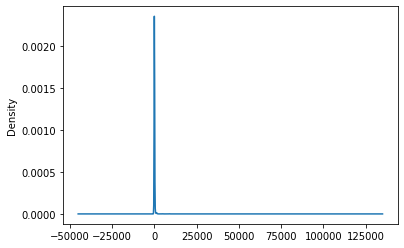

In [25]:
listings["price"].plot(kind="kde")

We can see most values are concentrated around zero according to the scale of the plot. Then, let's check those outliers.

Let's plot how many properties are rented for a price higher than 1000€.

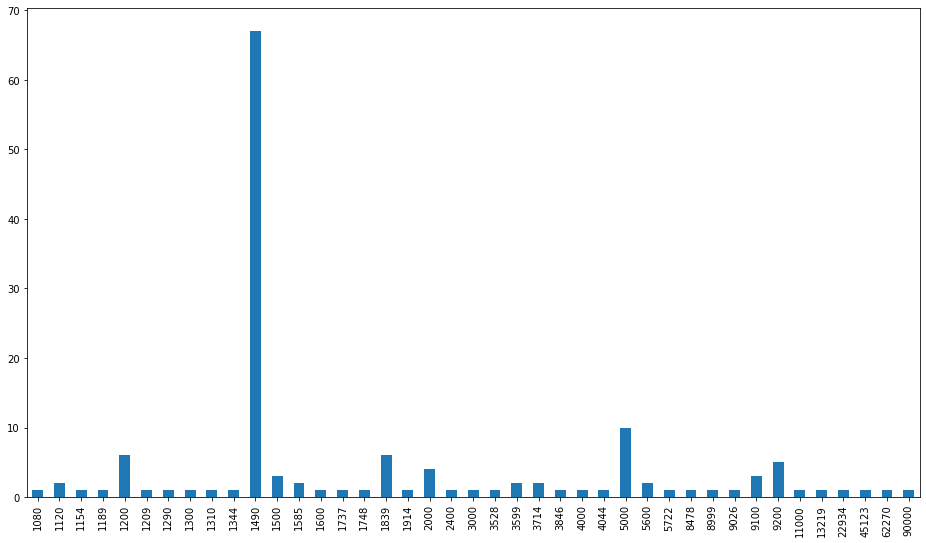

In [26]:
plt.figure(figsize=(16,9))
listings[listings["price"] > 1000]["price"].value_counts().sort_index().plot(kind="bar")
plt.xticks(size = 10);

There is a high frequency for 1490€. We should investigate more about this.

In [27]:
listings[listings["price"] == 1490]

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365
10587,48415873,Relaxing Double Single Use Standard At Barrio ...,175128252,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.38298,2.18181,Private room,1490,1,363
10972,50389602,Quiet Triple With Balcony At Eixample,175128252,Eixample,l'Antiga Esquerra de l'Eixample,41.39298,2.15736,Private room,1490,1,363
10983,50392729,Charming Double Comfort At Paseo De Gracia,175128252,Eixample,la Dreta de l'Eixample,41.39340,2.17266,Private room,1490,1,363
10994,50393164,Available Double Or Twin Standard At Sarria Area,175128252,Sarrià-Sant Gervasi,el Putxet i el Farró,41.40149,2.15079,Private room,1490,1,363
10995,50393184,Large Triple With Kitchenette At Sarria Area,175128252,Sarrià-Sant Gervasi,el Putxet i el Farró,41.40157,2.14924,Private room,1490,1,363
...,...,...,...,...,...,...,...,...,...,...,...
11278,50769265,Firstclass Double Deluxe At Las Ramblas,175128252,Ciutat Vella,el Raval,41.37932,2.17063,Private room,1490,1,363
11279,50769291,Deluxe Double Standard At Las Ramblas,175128252,Ciutat Vella,el Raval,41.37945,2.17040,Private room,1490,1,363
11280,50769318,Deluxe Family Room Capacity 2 At Las Ramblas,175128252,Ciutat Vella,el Raval,41.38140,2.17086,Private room,1490,1,363
11295,50904667,Huge Double Or Twin Superior At Paseo De Gracia,175128252,Gràcia,la Vila de Gràcia,41.39845,2.15824,Private room,1490,1,363


There are 67 private rooms with the same exact price. Also, the host_id is the same for all of them.

In [28]:
listings[listings["price"] == 1490]["host_id"].unique()

array([175128252], dtype=int64)

Does the host only offer private rooms for 1490€?

In [29]:
listings[listings["host_id"] == 175128252]["price"].value_counts()

1490    67
1839     6
Name: price, dtype: int64

We are going to remove the 67 private rooms at 1490€. Only that host_id offers that renting price, so we are going to remove all the records with that price.

In [30]:
listings = listings[ (listings["price"] != 1490)]

Conclusion:
- The remaining data do not indicate any error value inside the dataset, as it could be 99999€ for example. Then we are not going to change any value here.

Checking the minimum values for "price":

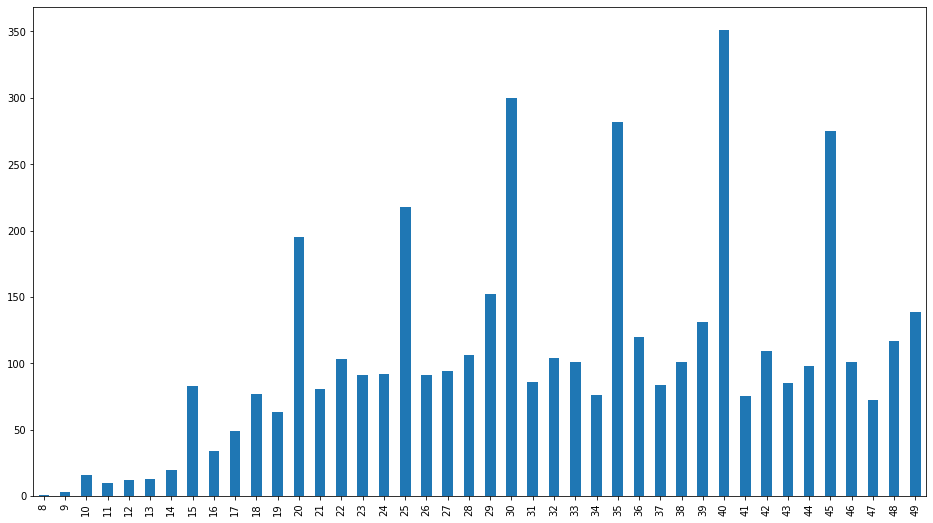

In [31]:
plt.figure(figsize=(16,9))
listings[listings["price"] < 50]["price"].value_counts().sort_index().plot(kind="bar")
plt.xticks(size = 10);

There is a high frequency of values for 20€. Below that it is going to be difficult to obtain any revenue. Then we are going to discard any property below 20€.

In [32]:
listings = listings[listings["price"] >= 20]

Check maximum values of "minimum_nights".

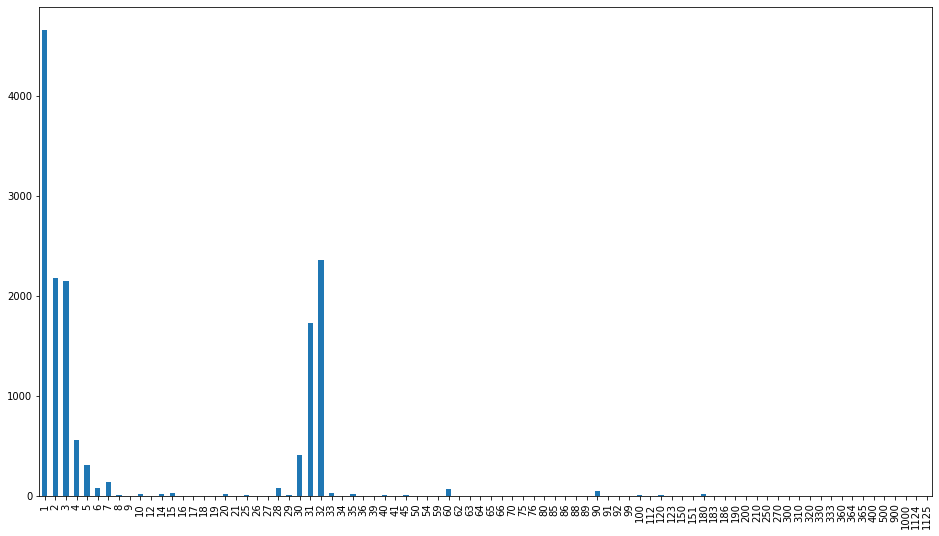

In [33]:
plt.figure(figsize=(16,9))
listings[listings["minimum_nights"] >= 0]["minimum_nights"].value_counts().sort_index().plot.bar();

Conclusion:
- Most properties require 1 minimum night.
- There are minimum night requirements up to 1125 nights. 

Since the company is interested in touristic apartments, the maximum allowed stay in a property is assumed to be 30 days. Then, all properties with a minimum night requirement higher than 30 are going to be discarded.

In [34]:
listings = listings.query('minimum_nights <= 30')

After checking the numerical dtypes, the summary is the following:

In [35]:
listings.iloc[:,7:].describe().T

,count,mean,std,min,25%,50%,75%,max
price,10723.0,152.897230,1066.414407,20.0,52.0,92.0,140.0,90000.0
minimum_nights,10723.0,3.519537,6.138493,1.0,1.0,2.0,3.0,30.0
availability_365,10723.0,180.141005,138.218417,0.0,20.0,189.0,321.0,365.0


The are still some outliers that distorts the mean for the numerical data types. 

Then, it is going to be considered the median instead of the mean when analysing the data in later sections.

### listings_det dataframe

In [36]:
listings_det.head()

,index,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,18674,https://www.airbnb.com/rooms/18674,20221211170659,2022-12-11,city scrape,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,...,4.69,4.81,4.28,HUTB-002062,t,20,20,0,0,0.28
1,1,124342,https://www.airbnb.com/rooms/124342,20221211170659,2022-12-11,city scrape,BORN CENTRICO / MUSEO PICASSO / 10 min to BEACH,Double room at El Born / MONTHLY RENTAL & DAY...,None,https://a0.muscache.com/pictures/6058611/f5160...,...,4.88,4.95,4.49,HUTB-123456,f,1,0,1,0,0.56
2,2,128463,https://www.airbnb.com/rooms/128463,20221211170659,2022-12-12,city scrape,Private Suite in residential area!!,My House is located in the quiet district of S...,You live in a typical Spanish district with no...,https://a0.muscache.com/pictures/855084/c71b65...,...,4.90,4.73,4.82,HUTB-012603,t,1,0,1,0,2.53
3,3,130227,https://www.airbnb.com/rooms/130227,20221211170659,2022-12-11,city scrape,Spacious Room with Pool and Terrace,Just 5 minutes’ walk from the beach in the San...,None,https://a0.muscache.com/pictures/14284828/d2ea...,...,4.78,4.73,4.64,Exempt,f,1,0,1,0,1.24
4,4,135513,https://www.airbnb.com/rooms/135513,20221211170659,2022-12-11,city scrape,APARTMENT AT RAMBLA POBLE NOU AND BEACH,AMAZING APARTMENT AT RAMBLA OF POBLE NOU ; ONL...,None,https://a0.muscache.com/pictures/9578738/40581...,...,4.80,4.83,4.56,None,f,2,2,0,0,0.96


In [37]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15778 entries, 0 to 15777
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         15778 non-null  int64  
 1   id                                            15778 non-null  int64  
 2   listing_url                                   15778 non-null  object 
 3   scrape_id                                     15778 non-null  int64  
 4   last_scraped                                  15778 non-null  object 
 5   source                                        15778 non-null  object 
 6   name                                          15769 non-null  object 
 7   description                                   15698 non-null  object 
 8   neighborhood_overview                         9193 non-null   object 
 9   picture_url                                   15778 non-null 

#### Variables and data types

We are going to use the variables that can provide any relevant information for the current project.

In [38]:
to_keep = ['id',
              'description',
              'host_is_superhost',
              'accommodates',
              'bathrooms',
              'bedrooms',
              'beds',
              'number_of_reviews',
              'review_scores_rating',
              'review_scores_communication',
              'review_scores_location'
             ]

listings_det = listings_det.loc[:, to_keep]

Check the data types

In [39]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15778 entries, 0 to 15777
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           15778 non-null  int64  
 1   description                  15698 non-null  object 
 2   host_is_superhost            15776 non-null  object 
 3   accommodates                 15778 non-null  int64  
 4   bathrooms                    0 non-null      float64
 5   bedrooms                     15197 non-null  float64
 6   beds                         15504 non-null  float64
 7   number_of_reviews            15778 non-null  int64  
 8   review_scores_rating         12501 non-null  float64
 9   review_scores_communication  12410 non-null  float64
 10  review_scores_location       12405 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 1.3+ MB


Conclusion: set "host_is_superhost" as categorical dtype

In [40]:
listings_det["host_is_superhost"] = listings_det["host_is_superhost"].astype("category")

#### Nulls analysis

In [41]:
listings_det.isna().sum()

id                                 0
description                       80
host_is_superhost                  2
accommodates                       0
bathrooms                      15778
bedrooms                         581
beds                             274
number_of_reviews                  0
review_scores_rating            3277
review_scores_communication     3368
review_scores_location          3373
dtype: int64

Conclusions:
- "description" is not relevant, so we can leave it as it is.
- "host_is_superhost" has very few nulls, so we can also leave it as it is.
- "bathrooms" is completely full of nulls. We are going to discard it.
- "bedrooms" is relevant for the project. We can replace the nulls using variables like "accommodates" or "beds"
- "beds" can be obtained from "accommodates" variable

Let's see if we can make a good guess for "beds" variable from "accommodates"

In [42]:
pd.crosstab(listings_det["beds"], listings_det["accommodates"])

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
1.0,1863,4195,192,284,14,13,1,2,1,0,0,0,0,0,0,0
2.0,92,797,813,1363,95,57,0,1,0,0,0,0,0,0,0,0
3.0,21,64,229,1193,459,364,11,17,0,0,0,0,0,0,0,0
4.0,31,15,29,388,424,544,81,77,2,3,1,0,0,0,0,0
5.0,17,2,4,33,162,364,92,105,14,29,0,1,1,1,0,0
6.0,11,1,1,13,12,185,54,162,20,20,2,4,0,1,0,0
7.0,1,0,0,2,2,13,32,69,26,34,3,4,1,5,0,0
8.0,5,0,0,1,0,6,5,28,16,27,4,2,1,1,1,1
9.0,0,0,0,0,1,0,0,2,7,14,1,8,2,2,2,2


Apparently we can assume the number of beds from the number of accommodates. By reading the crosstab we can see that:
- One or two people can be associated to one bed
- Three or four people can be associated to two beds
- Five or six people can be associated to three beds
- For more than 6 people we are going to assign four beds

Check the amount of nulls and the frequency of all values

In [43]:
listings_det["beds"].value_counts(dropna=False).sort_index()

1.0     6565
2.0     3218
3.0     2358
4.0     1595
5.0      825
6.0      486
7.0      192
8.0       98
9.0       41
10.0      48
11.0       7
12.0      16
13.0       6
14.0      13
15.0      12
16.0       8
18.0       6
19.0       2
20.0       6
26.0       1
30.0       1
NaN      274
Name: beds, dtype: int64

We are going to define a function for assigning the missing beds values according to the number of accommodates as we just defined.

In [44]:
def change_nulls(record):
    # List of conditions
    conditions = [(record["accommodates"] <= 2),
                (record["accommodates"] > 2) & (record["accommodates"] <= 4),
                (record["accommodates"] > 4) & (record["accommodates"] <= 6),
                (record["accommodates"] > 6)]
    
    # List of results
    results = [1,2,3,4,]

    # Output
    return(np.select(conditions, results, default=-999))

# Applying the fuction to the nulls values of "beds"
listings_det.loc[listings_det["beds"].isna(),"beds"] = listings_det[listings_det["beds"].isna()].apply(change_nulls, axis=1).astype('float64')


Now we can check if the changes have been applied and how the new value counts distribution is very different from the original one.

In [45]:
listings_det["beds"].value_counts(dropna=False).sort_index()

1.0     6786
2.0     3261
3.0     2365
4.0     1598
5.0      825
6.0      486
7.0      192
8.0       98
9.0       41
10.0      48
11.0       7
12.0      16
13.0       6
14.0      13
15.0      12
16.0       8
18.0       6
19.0       2
20.0       6
26.0       1
30.0       1
Name: beds, dtype: int64

Let's see if we can also guess the number of bedrooms according to the number of accommodates.

In [46]:
pd.crosstab(listings_det["bedrooms"], listings_det["accommodates"])

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
bedrooms,,,,,,,,,,,,,,,,
1.0,1974,4655,665,991,49,35,1,20,0,10,0,3,0,3,0,1
2.0,29,156,509,1915,494,579,18,15,0,1,1,1,0,0,0,0
3.0,22,22,35,277,577,809,159,202,20,18,1,2,0,1,0,0
4.0,25,9,2,44,46,121,97,212,37,59,8,14,2,0,2,1
5.0,15,2,0,0,2,4,3,16,26,51,2,7,5,6,2,0
6.0,1,0,0,0,0,2,0,1,4,8,0,11,3,7,6,17
7.0,5,0,0,0,0,0,0,1,0,2,0,1,0,4,0,2
8.0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9
9.0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5


The correlation between bedrooms and accommodates is not so straight forward. 

Let's compare beds and bedrooms.

In [47]:
pd.crosstab(listings_det["bedrooms"], listings_det["beds"])

beds,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,12.0,13.0,14.0,15.0,16.0,18.0,19.0,20.0,26.0,30.0
bedrooms,,,,,,,,,,,,,,,,,,,,,
1.0,6246,1614,348,109,23,29,2,17,0,5,...,6,0,3,0,4,0,0,0,1,0
2.0,91,1456,1345,653,142,24,4,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3.0,32,24,636,636,471,277,50,12,5,2,...,0,0,0,0,0,0,0,0,0,0
4.0,18,2,4,192,153,133,101,41,14,15,...,2,0,1,1,1,0,0,0,0,0
5.0,10,1,0,3,34,17,29,21,10,12,...,2,0,1,0,0,0,0,0,0,0
6.0,1,0,0,0,1,5,4,5,9,9,...,3,6,5,7,0,2,1,0,0,0
7.0,5,0,0,0,0,0,2,0,1,3,...,1,0,1,1,0,0,0,0,0,0
8.0,3,0,0,0,0,0,0,0,0,0,...,2,0,0,2,0,0,1,4,0,0
9.0,2,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,3,0,0,0,0


The correlation seems to be more clear here.

Conclusions:
- One or two beds usually correspond to one bedroom.
- Three or four beds usually corresponds with two bedrooms.
- Five or six beds usually correspond to three bedrooms.
- For more than six beds we are going to assign four bedrooms.

We are going to follow the same exact procedure we did with beds nulls analysis.

Check the amount of nulls and the frequency of all values

In [48]:
listings_det["bedrooms"].value_counts(dropna=False).sort_index()

1.0     8407
2.0     3718
3.0     2145
4.0      679
5.0      141
6.0       60
7.0       15
8.0       13
9.0        8
10.0       5
11.0       3
12.0       2
20.0       1
NaN      581
Name: bedrooms, dtype: int64

Apply the same function to change nulls for bedrooms analysis.

In [49]:
def change_nulls(record):
    # List of conditions
    conditions = [(record["beds"] <= 2),
                (record["beds"] > 2) & (record["beds"] <= 4),
                (record["beds"] > 4) & (record["beds"] <= 6),
                (record["beds"] > 6)]
    
    # List of results
    results = [1,2,3,4]

    # Output
    return(np.select(conditions, results, default=-999))

# Applying the fuction to the nulls values of "bedrooms"
listings_det.loc[listings_det["bedrooms"].isna(),"bedrooms"] = listings_det[listings_det["bedrooms"].isna()].apply(change_nulls, axis=1).astype('float64')

We can check how the changes have been applied.

In [50]:
listings_det["bedrooms"].value_counts(dropna=False).sort_index()

1.0     8948
2.0     3755
3.0     2147
4.0      680
5.0      141
6.0       60
7.0       15
8.0       13
9.0        8
10.0       5
11.0       3
12.0       2
20.0       1
Name: bedrooms, dtype: int64

Last but not least, we are going to remove the variable "bathrooms".

In [51]:
listings_det.drop(columns="bathrooms", inplace=True)
listings_det.head()

,id,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,18674,110m2 apartment to rent in Barcelona. Located ...,f,8,3.0,6.0,33,4.31,4.69,4.81
1,124342,Double room at El Born / MONTHLY RENTAL & DAY...,f,2,1.0,1.0,79,4.56,4.88,4.95
2,128463,My House is located in the quiet district of S...,t,2,1.0,1.0,347,4.87,4.90,4.73
3,130227,Just 5 minutes’ walk from the beach in the San...,f,2,3.0,1.0,130,4.72,4.78,4.73
4,135513,AMAZING APARTMENT AT RAMBLA OF POBLE NOU ; ONL...,f,5,2.0,3.0,131,4.64,4.80,4.83


### Duplicate analysis

In [52]:
listings_det.duplicated().sum()

0

In [53]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15778 entries, 0 to 15777
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           15778 non-null  int64   
 1   description                  15698 non-null  object  
 2   host_is_superhost            15776 non-null  category
 3   accommodates                 15778 non-null  int64   
 4   bedrooms                     15778 non-null  float64 
 5   beds                         15778 non-null  float64 
 6   number_of_reviews            15778 non-null  int64   
 7   review_scores_rating         12501 non-null  float64 
 8   review_scores_communication  12410 non-null  float64 
 9   review_scores_location       12405 non-null  float64 
dtypes: category(1), float64(5), int64(3), object(1)
memory usage: 1.1+ MB


#### Categorical dtypes analysis

Let's analyse the values and the frequencies of each categorical dtype.

In [54]:
listings_det["host_is_superhost"].value_counts()

f    13018
t     2758
Name: host_is_superhost, dtype: int64

#### Numerical dtypes analysis


In [55]:
listings_det.describe(include = "number").T

,count,mean,std,min,25%,50%,75%,max
id,15778.0,1.399492e+17,2.722666e+17,18674.0,18551274.00,37071296.00,52665837.25,7.787521e+17
accommodates,15778.0,3.465522e+00,2.188258e+00,0.0,2.00,3.00,4.00,1.600000e+01
bedrooms,15778.0,1.717074e+00,1.041176e+00,1.0,1.00,1.00,2.00,2.000000e+01
beds,15778.0,2.406642e+00,1.872581e+00,1.0,1.00,2.00,3.00,3.000000e+01
number_of_reviews,15778.0,4.244860e+01,8.054821e+01,0.0,1.00,8.00,45.00,1.476000e+03
review_scores_rating,12501.0,4.521144e+00,6.338666e-01,0.0,4.38,4.67,4.88,5.000000e+00
review_scores_communication,12410.0,4.701990e+00,4.801364e-01,0.0,4.62,4.85,5.00,5.000000e+00
review_scores_location,12405.0,4.749411e+00,3.746384e-01,0.0,4.67,4.85,5.00,5.000000e+00


There is nothing strange. 

Quality problems for numerical dtypes have already been solved, so we can proceed to create the data mart by joining both tables.

## Creating the data mart

We are going to join the two tables:
- listings
- listings_det

The main table will be "listings" and the field "id" will be used to join both tables.

On the other hand, there's also the "price_m2" table, that will join the other two by the field "neighbourhood_group". First, we need to check that "price_m2" and listings common variable names are the same. Then, we will have to check that.

First, let's join the main listings tables. The resulting table will have the same records as "listings" and a number of columns equal to the sum of both tables minus one, the id field will be the same for both tables.

In [56]:
listings.shape

(10723, 11)

In [57]:
listings_det.shape

(15778, 10)

The resulting table should have 10790 rows and 20 columns.

In [58]:
df = pd.merge(left=listings, right=listings_det, how="left", on="id")
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Eixample,la Sagrada Família,41.405560,2.172620,Entire home/apt,129,1,264,110m2 apartment to rent in Barcelona. Located ...,f,8,3.0,6.0,33,4.31,4.69,4.81
1,23197,"Forum CCIB DeLuxe, Spacious, Elegant ,Christmas",90417,Sant Martí,el Besòs i el Maresme,41.412430,2.219750,Entire home/apt,195,4,255,"Beautiful spacious apartment, large terrace, 5...",t,5,3.0,4.0,65,4.75,4.98,4.58
2,32711,Sagrada Familia area - Còrsega 1,135703,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.405660,2.170150,Entire home/apt,73,2,276,A lovely two bedroom apartment only 250 m from...,f,6,2.0,3.0,83,4.40,4.84,4.86
3,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Ciutat Vella,el Barri Gòtic,41.379780,2.176230,Entire home/apt,174,5,139,Spacious apartment for large families or group...,f,9,4.0,6.0,190,4.51,4.68,4.69
4,40983,Classical loft close to pedrera!,177617,Eixample,la Dreta de l'Eixample,41.396310,2.168320,Entire home/apt,60,2,267,Our cool and comfortable one bedroom apartment...,f,4,1.0,1.0,254,4.37,4.77,4.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10718,769312972900388299,Office + Room 30m2,88699083,Eixample,la Dreta de l'Eixample,41.395465,2.157356,Private room,262,1,348,"This special place is close to everything, mak...",t,3,1.0,2.0,0,NaN,NaN,NaN
10719,778252160406242566,Piso en Sagrada Familia,100663057,Horta-Guinardó,el Baix Guinardó,41.411795,2.172714,Entire home/apt,90,1,360,El piso cuenta con una habitación doble y una ...,f,3,2.0,2.0,0,NaN,NaN,NaN
10720,778273561693092293,Habitación increíble,1853836,Eixample,el Fort Pienc,41.399718,2.179879,Private room,39,2,355,Este apartamento tiene una inmejorable ubicaci...,f,1,1.0,1.0,0,NaN,NaN,NaN
10721,778744003177617387,Amazing loft in Born area Wifi,220918313,Sant Andreu,Sant Andreu,41.434496,2.190759,Entire home/apt,50,14,15,Beautiful recently fully restored 24sq meters ...,f,2,1.0,1.0,0,NaN,NaN,NaN


Let's proceed with joining price_m2 to df.

First let's check the field we want to join them both have the same values, so we can actually join them.

For the external data set of "price_m2":

In [59]:
price_m2["neighbourhood_group"].unique().shape

(10,)

For the data set "df":

In [60]:
df["neighbourhood_group"].unique().shape

(10,)

They have the same number of neighbourhood groups. Let's see they have the same lables.

In [61]:
pd.Series(price_m2["neighbourhood_group"].unique()).sort_values().to_numpy()

array(['Ciutat Vella', 'Eixample', 'Gràcia', 'Horta Guinardó',
       'Les Corts', 'Nou Barris', 'Sant Andreu', 'Sant Martí',
       'Sants-Montjuïc', 'Sarrià-Sant Gervasi'], dtype=object)

In [62]:
pd.Series(df["neighbourhood_group"].unique().categories).sort_values().to_numpy()

array(['Ciutat Vella', 'Eixample', 'Gràcia', 'Horta-Guinardó',
       'Les Corts', 'Nou Barris', 'Sant Andreu', 'Sant Martí',
       'Sants-Montjuïc', 'Sarrià-Sant Gervasi'], dtype=object)

There is one neighbourhood group which is not labeled in the same way. It is the case of 'Horta Guinardó'.
Let's fix this by changing the label in "price_m2" data frame.

In [63]:
price_m2["neighbourhood_group"] = price_m2["neighbourhood_group"].map({"Horta Guinardó":"Horta-Guinardó"}).fillna(price_m2["neighbourhood_group"])

We can join both dataframes.

In [64]:
df = pd.merge(left = df, right = price_m2, how = "left", left_on = "neighbourhood_group", right_on = "neighbourhood_group")
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,price_m2
0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Eixample,la Sagrada Família,41.405560,2.172620,Entire home/apt,129,1,...,110m2 apartment to rent in Barcelona. Located ...,f,8,3.0,6.0,33,4.31,4.69,4.81,4835
1,23197,"Forum CCIB DeLuxe, Spacious, Elegant ,Christmas",90417,Sant Martí,el Besòs i el Maresme,41.412430,2.219750,Entire home/apt,195,4,...,"Beautiful spacious apartment, large terrace, 5...",t,5,3.0,4.0,65,4.75,4.98,4.58,3544
2,32711,Sagrada Familia area - Còrsega 1,135703,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.405660,2.170150,Entire home/apt,73,2,...,A lovely two bedroom apartment only 250 m from...,f,6,2.0,3.0,83,4.40,4.84,4.86,4491
3,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Ciutat Vella,el Barri Gòtic,41.379780,2.176230,Entire home/apt,174,5,...,Spacious apartment for large families or group...,f,9,4.0,6.0,190,4.51,4.68,4.69,4165
4,40983,Classical loft close to pedrera!,177617,Eixample,la Dreta de l'Eixample,41.396310,2.168320,Entire home/apt,60,2,...,Our cool and comfortable one bedroom apartment...,f,4,1.0,1.0,254,4.37,4.77,4.88,4835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10718,769312972900388299,Office + Room 30m2,88699083,Eixample,la Dreta de l'Eixample,41.395465,2.157356,Private room,262,1,...,"This special place is close to everything, mak...",t,3,1.0,2.0,0,NaN,NaN,NaN,4835
10719,778252160406242566,Piso en Sagrada Familia,100663057,Horta-Guinardó,el Baix Guinardó,41.411795,2.172714,Entire home/apt,90,1,...,El piso cuenta con una habitación doble y una ...,f,3,2.0,2.0,0,NaN,NaN,NaN,3093
10720,778273561693092293,Habitación increíble,1853836,Eixample,el Fort Pienc,41.399718,2.179879,Private room,39,2,...,Este apartamento tiene una inmejorable ubicaci...,f,1,1.0,1.0,0,NaN,NaN,NaN,4835
10721,778744003177617387,Amazing loft in Born area Wifi,220918313,Sant Andreu,Sant Andreu,41.434496,2.190759,Entire home/apt,50,14,...,Beautiful recently fully restored 24sq meters ...,f,2,1.0,1.0,0,NaN,NaN,NaN,3192


Check that there are no nulls on "price_m2" variable to check the joining was successful.

In [65]:
df["price_m2"].isna().sum()

0

## Saving the data in the database

In order to keep the work saved in the database (so we don't have to repeat all the work again), we load the dataframe df into the airbnb.db file.

In [66]:
df.to_sql("df", con = con, if_exists = "replace")